In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyber-bullying-data-for-multi-label-classification/Data_Distribution.png
/kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv
/kaggle/input/cyber-bullying-data-for-multi-label-classification/hateXplain.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        """
        Args:
            inputs (list of list of int): List of input sequences (fixed length).
            outputs (list of list of list of int): List of one-hot encoded outputs (variable lengths).
            num_classes (int): Number of classes for one-hot encoding.
        """
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import emoji

import torch
import torch.nn.functional as F
# import torchtext
import random
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset

class TextPreProcessor:
    def __init__(self, file_path, unk_rate=0.05, specials=['<pad>', '<unk>']):
        
        print(f'Initializing TextPreProcessor.. \nReading file... {file_path}')
        # Read the CSV file
        self.df = pd.read_csv(file_path)
        self.df.fillna('None', inplace=True)      # Handelling Missing values...(with a simple imputation)
#         print(self.df.info())
            
        self.doc = self.tokenize()

        self.unk_rate = unk_rate
        self.specials = specials
        self.word_vocab = self.build_vocab(special_first=True)
        
        print("\nCreating the word-to-index map...")
        self.word_to_index = {token: idx for idx, token in enumerate(self.word_vocab.get_itos())}

        print("Creating the index-to-word map...")
        self.index_to_word = {idx: token for idx, token in enumerate(self.word_vocab.get_itos())} 
        
        self.total_words = len(self.word_vocab)
        print(f'total_words in vocab {self.total_words}')
        print("\nDataset is Preprocessed Successfully..!!")

    
    
    # ****************************** Functions for Pre-Processing Training Data *******************************
    
    # Function to preprocess emojis..
    def preprocess_emoji(self, text):
        return emoji.demojize(text, delimiters=(" ", " "))

    # Function for tokenizing Data..
    def tokenize(self):
        print(f'\nTokenizing Corpus of Length {len(self.df)}...')
        
        # First Convert Emojis into Proper form and Tokenize sentences based on split() function
        sentences = self.df['comment'].apply(lambda x: self.preprocess_emoji(x).split())
        
        sentences = sentences.tolist()   # convert it to a list..
        
        print(f"\n\nBefore Tokenization : \n{self.df['comment'].tolist()[:5]}")
        print(f"\n\nAfter Tokenization : \n{sentences[:5]}")
        
        return sentences
        
    
    # Function for Building the Vocabulary
    def build_vocab(self, special_first=True):
        specials = self.specials if special_first else []
        print("\nBuilding Vocabulary... ")
        word_vocab = build_vocab_from_iterator(
            self.doc,
            min_freq=1,
            specials=specials,
        )
        print(f'\n\nLength of Vocabulary : {len(word_vocab)}\nSample Vocabulary --> {list(word_vocab.get_itos())[:10]}')
        return word_vocab


    # adding random <unk> or out-of-vocabulary tokens..
    def add_random_unk_tokens(self, ngram):
        for idx, word in enumerate(ngram[:-1]):
            if random.uniform(0, 1) < self.unk_rate:
                ngram[idx] = '<unk>'
        return ngram
    
    
    # converting words into numerical tokens..
    def text_to_numerical_sequence(self, tokenized_text):
        tokens_list = []
        if tokenized_text[-1] in self.word_to_index:
            for token in tokenized_text[:-1]:
                num_token = self.word_to_index[token] if token in self.word_to_index  else self.word_to_index['<unk>']
                tokens_list.append(num_token)
            num_token = self.word_to_index[tokenized_text[-1]]
            tokens_list.append(num_token)
            return tokens_list
        return None
    
    
    # Function for Padding data and converting into Tensors..
    def pad_sequence(self, X, max_length):
        padded_X = []
        
        print(f'\nPadding Features to Maximum length {max_length} ...')
        for sequence in X:
            padded_seq = F.pad(torch.tensor(sequence), (max_length - len(sequence),0), value=0)
            padded_X.append(padded_seq)
        
        print(f'Converting Data into torch Tensors...')
        padded_X = torch.stack(padded_X)
        
        return padded_X
    
    
    
    # *********************************** Functions to process labels *******************************************
    def one_hot_encode(self, label, num_classes):
        """Convert labels to one-hot encoded format."""
        one_hot = np.zeros(num_classes)
        one_hot[label] = 1
        return one_hot


    def process_labels(self):
        # Define the columns to be one-hot encoded
        categorical_columns = self.df.columns[1:]
        df = self.df[categorical_columns]
#         categorical_columns = ['label','Race', 'Religion', 'Gender', 'Sexual Orientation', 'Miscellaneous']

        # Find unique values for each categorical column
        unique_labels = {col: df[col].unique() for col in categorical_columns}

        # Print unique labels for each categorical column
        print("\n\n")
        for column, lbls in unique_labels.items():
            print(f"\nUnique labels in column '{column}' : {lbls}")

        # Initialize a dictionary to store LabelEncoders for each column
        label_encoders = {}
        
        # Apply LabelEncoder to each categorical column
        for column in categorical_columns:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le
            
        label_encoded = df.values.tolist()
        # Display the DataFrame to verify encoding
        print(f'\n\n\nSample after Label Encoding are --> {label_encoded[:5]}')

        print("\nGenerating Mappings for Each Category of Labels...")
        label_maps = []
        # Print mapping for each column
        for column, le in label_encoders.items():
            label_maps.append(dict(zip(le.classes_, le.transform(le.classes_))))        

        label_encoded_tensor = torch.tensor(label_encoded)
        y = label_encoded_tensor
        print("\n\nLabel mappings :\n")
        print(label_maps)
        
        return y, label_maps
    
    
    
    
    
    # ************************************ Dataset Creator Function to be called **********************************
    def create_dataset(self):
        
        print(f'Inserting <unk> token in the n_gram document randomly...')
        document_unk = [self.add_random_unk_tokens(data) for data in self.doc]
        print(f'\n\nSample Test_Set with random <unk> tokens -->\n{document_unk[:5]}')
        
        # Efficiently create data list without redundant calls
        X = [seq for seq in (self.text_to_numerical_sequence(sequence) for sequence in document_unk)]
        print(f'\n\nTotal input sequences: {len(X)}')
        print(f'\nSample document :\n{X[:5]}') 
        
        # calculating the logest sequence in the data..
        longest_sequence = max(len(sequence) for sequence in X)
        print(f'\nLongest Sequence in the Dataset has length {longest_sequence}')
        
        # padding data and converting it to tensor...
        padded_X = self.pad_sequence(X, longest_sequence)
        print("Sample Dataset after Padding :")
        print(padded_X[:2])
        
        
        
        # Processing Labels to make them ready for Model
        y, label_maps = self.process_labels()
#         print(f'\nShape of Labels : {y.shape}')
        dataset = TensorDataset(padded_X, y)
        print("\nTeansor Dataset Creation Successful!!")
        

        return dataset, longest_sequence, self.total_words, label_maps

In [4]:
processor = TextPreProcessor("/kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv")
dataset, longest_sequence, total_words, label_maps = processor.create_dataset()

Initializing TextPreProcessor.. 
Reading file... /kaggle/input/cyber-bullying-data-for-multi-label-classification/final_hateXplain.csv

Tokenizing Corpus of Length 20109...


Before Tokenization : 
['0 u0 lmao wow fuck you too 😂 😂', '1 0 th floor maybe wow cnn with the fakenews the body count is going to be waay bad too but we can all go home now they have the white ar <number> toting suicide shooter with huge drum mags dead on the 3 2 nd floor', '1 0 yrs <number> white women raped by niggers <number> negress raped by a cracker source fbi crime stats wake up rise up', '1 2 h ago ching chong accepted your friend request ❤️', '1 8 th century mayhem and lawlessness had nothing on loud mouthed donald trump the republicans of today congress these buffoons will be short lived 🙏 but i thought violation of twitter rules included threats and incitement to violence why has not twitter shut dopey donny down']


After Tokenization : 
[['0', 'u0', 'lmao', 'wow', 'fuck', 'you', 'too', 'face_with_tea

/tmp/ipykernel_24/738234434.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
/tmp/ipykernel_24/738234434.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column])
/tmp/ipykernel_24/738234434.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [5]:
from torch.utils.data import DataLoader, random_split, TensorDataset

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


# Print input and labels
for inputs, labels in train_loader:
    print("Input:", inputs)
    print("Labels:", labels)
    break  # Remove break to iterate through all batches

Input: tensor([[    0,     0,     0,  ...,     5,  6198,   788],
        [    0,     0,     0,  ...,  7662,  1704,  2798],
        [    0,     0,     0,  ...,    10,    78,  1906],
        ...,
        [    0,     0,     0,  ...,   828,    45,    80],
        [    0,     0,     0,  ...,    39,    13, 24581],
        [    0,     0,     0,  ...,    96,    91,   374]])
Labels: tensor([[1, 7, 5, 1, 4, 3],
        [2, 7, 5, 1, 4, 3],
        [0, 0, 5, 1, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [1, 7, 1, 1, 4, 4],
        [0, 2, 5, 1, 4, 3],
        [2, 0, 4, 1, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [2, 3, 5, 1, 4, 3],
        [1, 7, 5, 0, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [2, 7, 5, 2, 4, 3],
        [1, 7, 4, 1, 4, 3],
        [0, 2, 5, 2, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [0, 7, 5, 1, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [2, 7, 5, 1, 4, 3],
        [1, 7, 5, 1, 4, 3],
        [0, 7, 4, 2, 4, 3],
        [0, 3, 3, 1, 4, 4],
       

In [6]:
import torch
import torch.nn as nn

class My_BiLSTM(nn.Module):
    def __init__(self, word_vocab_total_words, embedding_dim, hidden_dim, num_layers, num_classes_list):
        super(My_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(word_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        
        # Define multiple classifiers for different lengths of one-hot encodings
        self.classifiers = nn.ModuleList([nn.Linear(hidden_dim * 2, num_classes) for num_classes in num_classes_list])

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)

        
        # Since the LSTM is bidirectional, we concatenate the last hidden state of the forward direction
        # and the first hidden state of the backward direction before passing it to the fully connected layer
        # For batch_first=True, the last timestep of the forward direction is lstm_out[:, -1, :hidden_dim]
        # and the first timestep of the backward direction is lstm_out[:, 0, hidden_dim:]
        forward_last = lstm_out[:, -1, :self.lstm.hidden_size]
        backward_first = lstm_out[:, 0, self.lstm.hidden_size:]
        
        out = torch.cat((forward_last, backward_first), dim=1)
        
        outputs = []
        for classifier in self.classifiers:
            outputs.append(classifier(out))
            
        return outputs

In [7]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# num_classes_list = [len(item) for item in label_maps]
# print(total_words)
# print(num_classes_list)

# embedding_dim = 256 
# hidden_dim = 256
# num_layers = 2

# model = My_BiLSTM(total_words, embedding_dim, hidden_dim, num_layers, num_classes_list).to(device)

In [8]:
# from tqdm import tqdm
# import torch.optim as optim
# import torch.nn.functional as F

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for epoch in range(num_epochs):
#     for i, (inputs, labels) in enumerate(tqdm(train_loader, desc= "trainning : ", leave = False)):
#         inputs = inputs.to(device)  # Add an extra dimension for the input

#         model.train()
        
#         # Forward pass
#         outputs = model(inputs)
        
#         # Compute loss for each classifier
#         loss = 0
#         for output, label in zip(outputs, labels.T):
# #             print(output.shape, label.shape)
#             output = output.to(device)
#             label = label.to(device)
#             loss += criterion(output, label)
        
#         # Backward pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {loss.item():.4f}')


In [9]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from operator import truediv
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns



def log_output(tr_loss, tr_acc, v_loss, v_acc, tst_loss, oa_ae, lr, epoch, EPOCHS, path):
    f = open(path, 'a')
    f.write(f"\n\n\nFor Learning_Rate : {lr} & Epochs : {EPOCHS}  (Early Stopping at {epoch})\n\nThe Result is ->\n\n")
    sentence0 = f"Train Loss : {tr_loss} | Train Acc : {tr_acc} | Valid Loss : {v_loss} | Valid Acc : {v_acc}\n"
    f.write(sentence0)
    sentence1 = 'Test Loss is: ' + str(tst_loss) + '\n' + 'OA(Top-1 Accuracy) is: ' + str(oa_ae) + '\n'
    f.write(sentence1)
    f.close()



def load_model(model_dict, model_path):
    if os.path.exists(model_path):
      print(f"\nLoading Saved Version of the Model {model_dict['name']} ....\n")
      model_dict['arch'].load_state_dict(torch.load(model_path)) 
    
    else :
      print(f"\nFOUND NO Previous Saved Version of the Model {model_dict['name']} ....\n")

    return model_dict['arch']  
    
  
def build_model(model_dict, dataset, train_loader, valid_loader, test_loader, EPOCHS = 50, LEARNING_RATE = 0.001, measure_performance=True):
    nclass = dataset['nclass']
    epochs = EPOCHS

    # Check if the directory exists, if not, create it..
    os.makedirs(os.path.dirname(f"./{dataset['folder']}/{model_dict['folder']}/"), exist_ok=True)


    CHECKPOINT_PATH = f"./{dataset['folder']}/{model_dict['folder']}/checkpoint_{dataset['name']}_{model_dict['name']}.pth"
    model = load_model(model_dict, CHECKPOINT_PATH ).to(device)
    name = dataset['name'] + "_" + model_dict['name']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Define the early stopping criteria
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_train_loss = float('inf')
    best_train_acc = 0.0
    patience = 10
    counter = 0

    # Lists to store accuracy and loss values
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    print(f"\nStarting Trainning... for model {model_dict['name']}\n\n")

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for _, (inputs, labels) in enumerate(tqdm(train_loader, desc= "trainning : ", leave = False)):
            inputs = inputs.to(device)
            labels = labels.T.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute loss for each classifier
            loss = 0
            for output, label in zip(outputs, labels):
                # print(output.shape, label.shape)
                output = output.to(device)
                label = label.to(device)
                
                loss += criterion(output, label)  # loss of current class # total loss calculation
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            for output, label in zip(outputs, labels):
                class_train_correct = 0.0
                _, predicted = torch.max(output.data, 1)
                train_correct += (predicted == label).sum().item()
                
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for _,(inputs, labels) in enumerate(tqdm(valid_loader, desc= "validating : ", leave = False)):
                inputs = inputs.to(device)
                labels = labels.T.to(device)

                outputs = model(inputs)
                # Compute loss for each classifier
                loss = 0
                for output, label in zip(outputs, labels):
                    # print(output.shape, label.shape)
                    output = output.to(device)
                    label = label.to(device)
                    
                    loss += criterion(output, label) # total loss calculation

                val_loss += loss.item() * inputs.size(0)
                for output, label in zip(outputs, labels):
                    _, predicted = torch.max(output.data, 1)
                    val_correct += (predicted == label).sum().item()

            val_loss /= len(valid_loader.dataset)
            val_acc = val_correct / len(valid_loader.dataset)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
        # Step the scheduler
        scheduler.step(val_loss)

        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
#               f"\n\nClasswise Train Acc : {[round(x, 4) for x in class_train_acc]}"
#               f"\nClasswise Val Acc : {[round(x, 4) for x in class_val_acc]}")




        # Early stopping based on validation loss
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            best_val_loss = val_loss
            best_train_acc = train_acc
            best_train_loss = train_loss
            
            # Save the model if it has the best validation accuracy
            torch.save(model.state_dict(), CHECKPOINT_PATH)
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break



    # Load the best model checkpoint for evaluation
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    top2_correct=0
    top5_correct=0

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(tqdm(test_loader, desc="Testing : ", leave=False)):
            inputs = inputs.to(device)
            labels = labels.T.to(device)

            outputs = model(inputs)
            
            loss=0.0
            for output, label in zip(outputs, labels):
                # print(output.shape, label.shape)
                output = output.to(device)
                label = label.to(device)
                
                loss += criterion(output, label)  # loss of current class 

            test_loss += loss.item() * inputs.size(0) # total loss calculation
            
            for output, label in zip(outputs, labels):
                _, predicted = torch.max(output.data, 1)
                test_correct += (predicted == label).sum().item()

        test_loss /= len(test_loader.dataset)
        test_acc = test_correct / len(test_loader.dataset)

    print(f"\nBEST MODEL --> \nTrain Acc : {best_train_acc:.4f} | Train Loss : {best_train_loss:.4f} | Valid Acc : {best_val_acc:.4f} | Valid Loss : {best_val_loss:.4f}")
    print(f"Test Loss : {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # Plot accuracy and loss curves
    plt.figure(figsize=(20, 20))
    plt.plot(train_acc_list, label='Train')
    plt.plot(val_acc_list, label='Validation')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig(f"./{dataset['folder']}/{model_dict['folder']}/Acc_{name}.png")
    plt.show()


    plt.figure(figsize=(20, 20))
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig(f"./{dataset['folder']}/{model_dict['folder']}/loss_{name}.png")
    plt.show()


    log_output(best_train_loss, best_train_acc, best_val_loss, best_val_acc, test_loss,test_acc, LEARNING_RATE, epoch, EPOCHS, f"./{dataset['folder']}/{model_dict['folder']}/results_{name}.txt")
    
    return model, [best_train_loss, best_train_acc, best_val_loss, best_val_acc, test_loss, test_acc]


FOUND NO Previous Saved Version of the Model biLSTM ....


Starting Trainning... for model biLSTM




Epoch: 1/100 | Train Loss: 4.7312 | Train Acc: 4.2982 | Val Loss: 4.5002 | Val Acc: 4.3109


Epoch: 2/100 | Train Loss: 4.6670 | Train Acc: 4.3096 | Val Loss: 4.5038 | Val Acc: 4.3109


Epoch: 3/100 | Train Loss: 4.6386 | Train Acc: 4.3158 | Val Loss: 4.4931 | Val Acc: 4.3109


Epoch: 4/100 | Train Loss: 4.6143 | Train Acc: 4.3197 | Val Loss: 4.5014 | Val Acc: 4.2338


Epoch: 5/100 | Train Loss: 4.6160 | Train Acc: 4.3146 | Val Loss: 4.4820 | Val Acc: 4.3109


Epoch: 6/100 | Train Loss: 4.6117 | Train Acc: 4.3214 | Val Loss: 4.4759 | Val Acc: 4.3109


Epoch: 7/100 | Train Loss: 4.5993 | Train Acc: 4.3116 | Val Loss: 4.5048 | Val Acc: 4.3114


Epoch: 8/100 | Train Loss: 4.5980 | Train Acc: 4.3154 | Val Loss: 4.4495 | Val Acc: 4.3109


Epoch: 9/100 | Train Loss: 4.5913 | Train Acc: 4.3203 | Val Loss: 4.4938 | Val Acc: 4.3109


Epoch: 10/100 | Train Loss: 4.5920 | Train Acc: 4.3184 | Val Loss: 4.4607 | Val Acc: 4.3109


Epoch: 11/100 | Train Loss: 4.5897 | Train Acc: 4.3136 | Val Loss: 4.4740 | Val Acc: 4.3109


Epoch: 12/100 | Train Loss: 4.5849 | Train Acc: 4.3226 | Val Loss: 4.4826 | Val Acc: 4.3109


Epoch: 13/100 | Train Loss: 4.5884 | Train Acc: 4.3232 | Val Loss: 4.4904 | Val Acc: 4.2338


Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 14/100 | Train Loss: 4.5909 | Train Acc: 4.3178 | Val Loss: 4.5085 | Val Acc: 4.3109


Epoch: 15/100 | Train Loss: 4.5174 | Train Acc: 4.3383 | Val Loss: 4.4377 | Val Acc: 4.3109


Epoch: 16/100 | Train Loss: 4.4996 | Train Acc: 4.3366 | Val Loss: 4.4363 | Val Acc: 4.3109


Epoch: 17/100 | Train Loss: 4.4979 | Train Acc: 4.3455 | Val Loss: 4.4399 | Val Acc: 4.3109
Early stopping!



BEST MODEL --> 
Train Acc : 4.3116 | Train Loss : 4.5993 | Valid Acc : 4.3114 | Valid Loss : 4.5048
Test Loss : 4.5111 | Test Acc: 4.3007


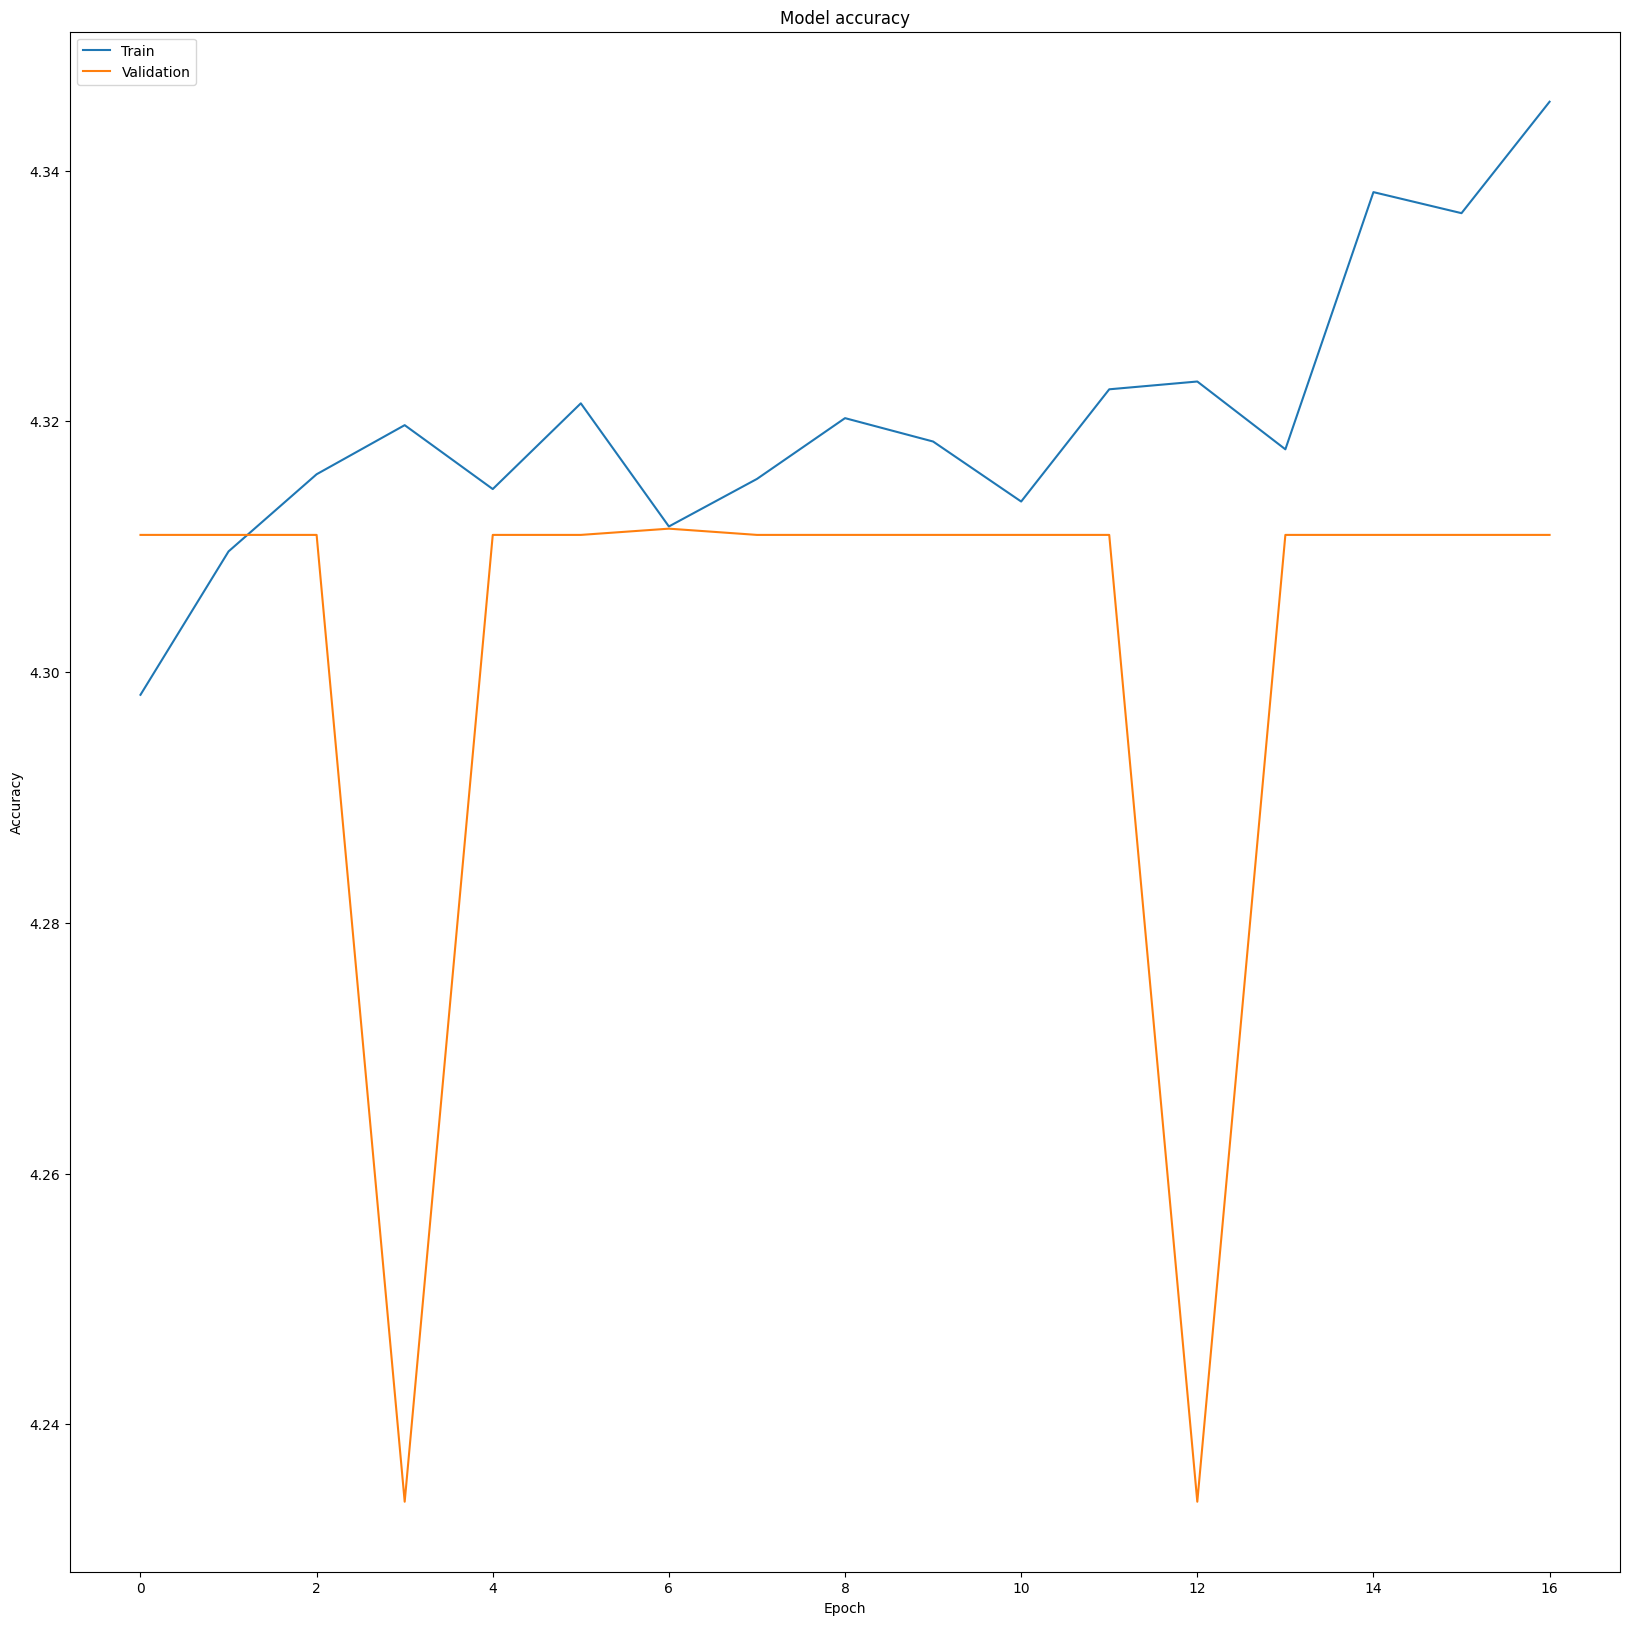

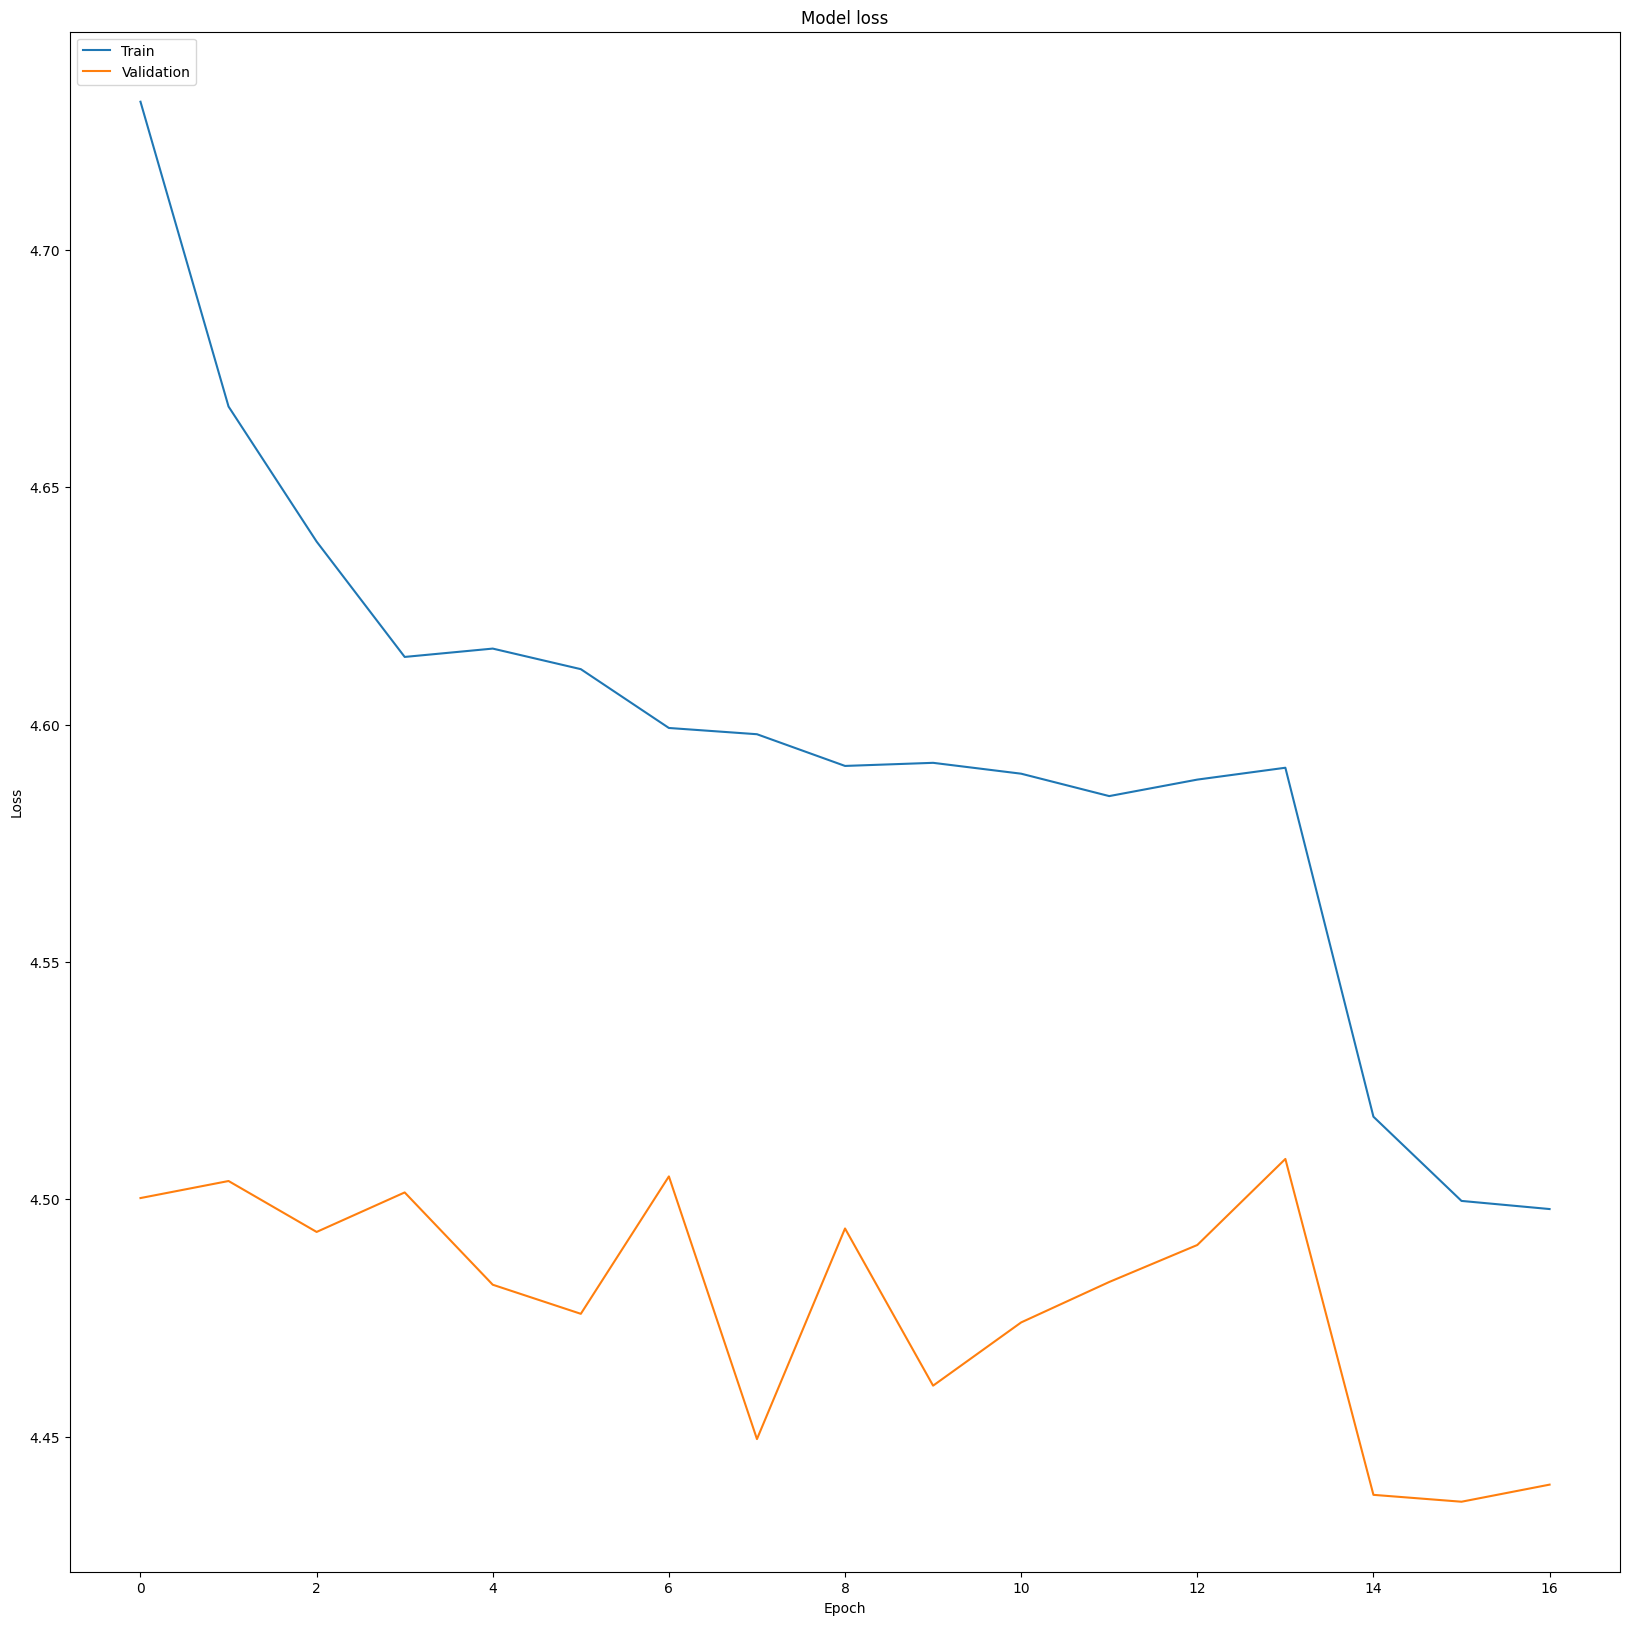

In [10]:
# datasets...
num_classes_list = [len(item) for item in label_maps]
hateXplain_data = dict(name="hateXplain", nclass=num_classes_list, folder="hateXplain")

# model dictionaries...
arch_dict = dict(name='biLSTM', arch=My_BiLSTM, folder='Bi_LSTM')

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# embedding_dim = 256 
# hidden_dim = 256
# num_layers = 4

# model = My_BiLSTM().to(device)


arch_name = arch_dict["name"]
model = arch_dict['arch'](word_vocab_total_words=total_words, embedding_dim=256, hidden_dim=256, num_layers=6, num_classes_list=hateXplain_data['nclass']).to(device)
model_dict = dict(name=f"{arch_name}", arch= model, folder=f"{arch_dict['folder']}")


model, results = build_model(model_dict, hateXplain_data, train_loader, val_loader, test_loader, EPOCHS=100, LEARNING_RATE=0.01)

results = [round(x, 4) for x in results]  # formatting into 4 decimal places.